In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
import os
import sys
print(sys.executable)
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity
plt.rcParams['font.sans-serif'] = ['SimHei']  # 支持中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号 '-' 显示问题
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

C:\Users\Acer\anaconda3\envs\tf-embedding\python.exe


In [2]:
df = pd.read_csv('F:\Graduate materials\论文\代码\output_combined.csv')
df['商品综合信息'] = df[['商品名称', '商品分类', '商品品牌']].fillna('').astype(str).agg(' '.join, axis=1)
empty_or_nan_or_count = (
    df['商品综合信息'].isna() | 
    (df['商品综合信息'] == "") | 
    df['商品综合信息'].apply(lambda x: isinstance(x, (int, float)))
)
print(f"空字符或 NaN 或数字的数量: {empty_or_nan_or_count.sum()}")
df = df[~ (df['商品综合信息'].isna() | (df['商品综合信息'] == ""))]

空字符或 NaN 或数字的数量: 0


In [3]:
import re

def clean_text(text):
    # 仅保留中文、英文、数字
    text = re.sub(r"[^a-zA-Z0-9\u4e00-\u9fff]", " ", text)  
    # 去除多余空格
    text = re.sub(r"\s+", " ", text).strip()  
    return text

# 对所有商品信息进行清理
df["商品综合信息"] = df["商品综合信息"].apply(clean_text) 

In [4]:
sentence_embeddings = np.load(".\\npy_document\\bert_multilingual_embeddings_8_length.npy")
sentence_embeddings.shape

(24358, 768)

# 确定分类数

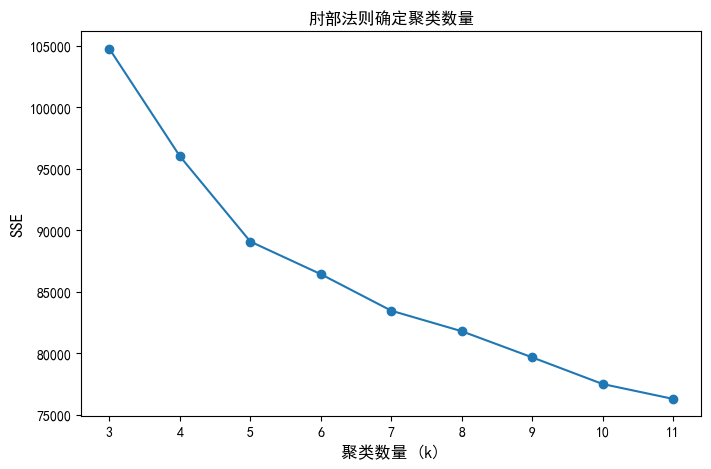

In [5]:
from sklearn.cluster import KMeans

SSE = []
K_range = range(3, 12)  # 选择从1到10个聚类
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42,n_init=8)
    kmeans.fit(sentence_embeddings)
    SSE.append(kmeans.inertia_)  # inertia_ 是 KMeans 的 SSE

# 绘制肘部法则图
plt.figure(figsize=(8, 5))
plt.plot(K_range, SSE, marker='o')
plt.xlabel('聚类数量 (k)')
plt.ylabel('SSE')
plt.title('肘部法则确定聚类数量')
plt.show()


最佳类别数量：2, 轮廓系数：0.8154
轮廓系数 图像已保存至 .\wiki_embeding_cluster\轮廓系数.png


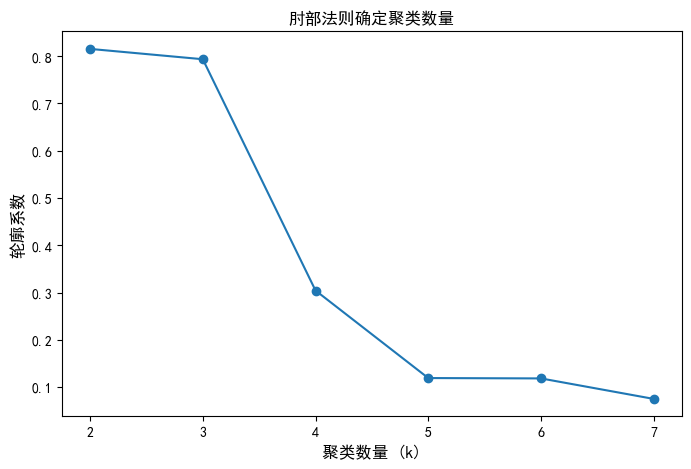

In [6]:
from sklearn.metrics import silhouette_score

best_k = 0
best_score = -1

silhouette = []

K_range = range(2, 8)

for k in K_range:  # 尝试从2到9类
    kmeans = KMeans(n_clusters=k, random_state=42,n_init=8)
    kmeans.fit(sentence_embeddings)
    labels = kmeans.labels_
    score = silhouette_score(sentence_embeddings, labels)
    silhouette.append(score)
    
    if score > best_score:
        best_k = k
        best_score = score

print(f"最佳类别数量：{best_k}, 轮廓系数：{best_score:.4f}")

# 绘制肘部法则图
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette, marker='o')
plt.xlabel('聚类数量 (k)')
plt.ylabel('轮廓系数')
plt.title('肘部法则确定聚类数量')

save_path = f'.\wiki_embeding_cluster\轮廓系数.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"轮廓系数 图像已保存至 {save_path}")

plt.show()

# 相似性矩阵

In [7]:
# 计算句子之间的余弦相似度
similarity_matrix = cosine_similarity(sentence_embeddings)

similarity_matrix[similarity_matrix < 0] = 0

np.fill_diagonal(similarity_matrix, 1)

# 打印相似度矩阵
print("余弦相似度矩阵：")
print(similarity_matrix)

余弦相似度矩阵：
[[1.         0.98604095 0.9873307  ... 0.98575634 0.97429836 0.98283905]
 [0.98604095 1.         0.9965712  ... 0.9906609  0.9811391  0.9885708 ]
 [0.9873307  0.9965712  1.         ... 0.9917777  0.98204565 0.99068755]
 ...
 [0.98575634 0.9906609  0.9917777  ... 1.         0.9870266  0.9968734 ]
 [0.97429836 0.9811391  0.98204565 ... 0.9870266  1.         0.99087775]
 [0.98283905 0.9885708  0.99068755 ... 0.9968734  0.99087775 1.        ]]


In [8]:
num_clusters = 3
spectral = SpectralClustering(
    n_clusters=num_clusters,
    affinity='precomputed',  # 直接使用相似性矩阵
    random_state=42
)
cluster_labels = spectral.fit_predict(similarity_matrix)


In [12]:
n=0
for text, label in zip(df['商品综合信息'], cluster_labels):
    if n<1000 and label==1:
        n+=1
        print(f"文本: {text} -> 聚类类别: {label}")

文本: 汾酒 汾酒 黄盖玻汾清香型口粮高度纯粮食白酒53度475ml 6瓶 12瓶 酒类 酒类 白酒 白酒 汾酒 -> 聚类类别: 1
文本: 迪士尼 童鞋儿童凉鞋男童夏季潮款女童运动鞋溯溪鞋儿童沙滩鞋DF 母婴宠物 童鞋 婴儿鞋 亲子鞋 凉鞋 Disney 迪士尼 -> 聚类类别: 1
文本: 洗面奶 兔头妈妈 儿童分龄洗面奶温和泡泡清洁保湿不紧绷wfdsp 母婴宠物 婴童用品 宝宝护肤 儿童洗面奶 兔头妈妈 -> 聚类类别: 1
文本: 极简洁面3岁 兔头妈妈极简净爽洁面学生清洁控油不紧绷ty 母婴宠物 婴童用品 宝宝护肤 儿童洗面奶 兔头妈妈 -> 聚类类别: 1
文本: 云上叙 18 V2223 岫玉手镯 11x9mm 多样性发一件 东哥 珠宝文玩 翡翠 和田玉 琥珀蜜蜡 其他玉石 其他天然玉石 岫玉 蛇纹石玉 手镯 云上叙 -> 聚类类别: 1
文本: 云上叙 16 A4808 南红单圈手串 9mm 东哥 珠宝文玩 翡翠 和田玉 琥珀蜜蜡 其他玉石 其他天然玉石 南红 手链 手串 云上叙 -> 聚类类别: 1
文本: 云上叙 14 V42778 南红圆珠多圈手串 5mm 东哥 珠宝文玩 翡翠 和田玉 琥珀蜜蜡 其他玉石 其他天然玉石 南红 手链 手串 云上叙 -> 聚类类别: 1
文本: 云上叙 13 V30230 南红单圈手串 11mm 东哥 珠宝文玩 翡翠 和田玉 琥珀蜜蜡 其他玉石 其他天然玉石 南红 手链 手串 云上叙 -> 聚类类别: 1
文本: 云上叙 2 V30371 南红多圈手串 5mm 东哥 珠宝文玩 翡翠 和田玉 琥珀蜜蜡 其他玉石 其他天然玉石 南红 手链 手串 云上叙 -> 聚类类别: 1
文本: 云上叙 18 V2223 岫玉手镯 11x9mm 多样性发一件 东哥 珠宝文玩 翡翠 和田玉 琥珀蜜蜡 其他玉石 其他天然玉石 岫玉 蛇纹石玉 手镯 云上叙 -> 聚类类别: 1
文本: 云上叙 7 A1499 南红单圈手串 8mm 东哥 珠宝文玩 翡翠 和田玉 琥珀蜜蜡 其他玉石 其他天然玉石 南红 手链 手串 云上叙 -> 聚类类别: 1
文本: 云上叙 13 A7912 南红DlY单圈手串 7mm 东哥 珠宝文玩 翡翠 和田玉 琥珀蜜蜡 其他玉石 其他天然玉石 南红 手链 手串 云上叙 -> 聚类类别: 1
文本: 云上叙 11 V

In [10]:
df['cluster_similarity'] = cluster_labels
print(df['cluster_similarity'].value_counts())
df_cluster_similarity = df[['商品名称', '商品分类', '商品品牌','cluster_similarity']]
# df_cluster_similarity[df_cluster_similarity['cluster_similarity'] == 1]

cluster_similarity
0    24148
1      112
2       98
Name: count, dtype: int64


In [ ]:
df_cluster_similarity.to_csv('.\BERT_embeding_cluster\BERT_cluster_similarity.csv', index=False)

# KMEANS聚类

In [13]:
from sklearn.decomposition import PCA
# # 🔹 降维（可选）
reducer = PCA(n_components=50)  # 可选用 UMAP

PCA_embeddings_reduced = reducer.fit_transform(sentence_embeddings)

In [30]:
import umap
umap_reducer = umap.UMAP(n_components=20)
UMAP_embeddings_reduced = umap_reducer.fit_transform(sentence_embeddings)

C:\Users\Acer\anaconda3\envs\tf-embedding\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
from sklearn.cluster import KMeans, DBSCAN
import hdbscan
# KMeans 聚类
kmeans = KMeans(n_clusters=3, random_state=42,n_init = 10)  # 你可以调整 n_clusters
df["cluster_kmeans"] = kmeans.fit_predict(PCA_embeddings_reduced)

# DBSCAN 聚类
dbscan = DBSCAN(eps=2.0, min_samples=500)
df["cluster_dbscan"] = dbscan.fit_predict(PCA_embeddings_reduced)

# HDBSCAN（更适合不同密度的聚类）
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=500, min_samples=2, cluster_selection_epsilon=1.6)
df["cluster_hdbscan"] = hdbscan_model.fit_predict(PCA_embeddings_reduced)


In [16]:
print(df['cluster_kmeans'].value_counts())
print(df['cluster_dbscan'].value_counts())
df['cluster_hdbscan'].value_counts()

cluster_kmeans
0    23752
2      350
1      256
Name: count, dtype: int64
cluster_dbscan
 0    23603
-1      755
Name: count, dtype: int64


cluster_hdbscan
-1    11935
 1    11892
 0      531
Name: count, dtype: int64

In [51]:
from sklearn.manifold import TSNE

# ✅ 使用 t-SNE 降到 2 维
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(sentence_embeddings)
# 添加降维结果到 DataFrame
df["tsne_x"] = tsne_results[:, 0]
df["tsne_y"] = tsne_results[:, 1]

聚类结果已保存至 .\BERT_embeding_cluster\BERT -cluster_kmeans 聚类 (t-SNE).png


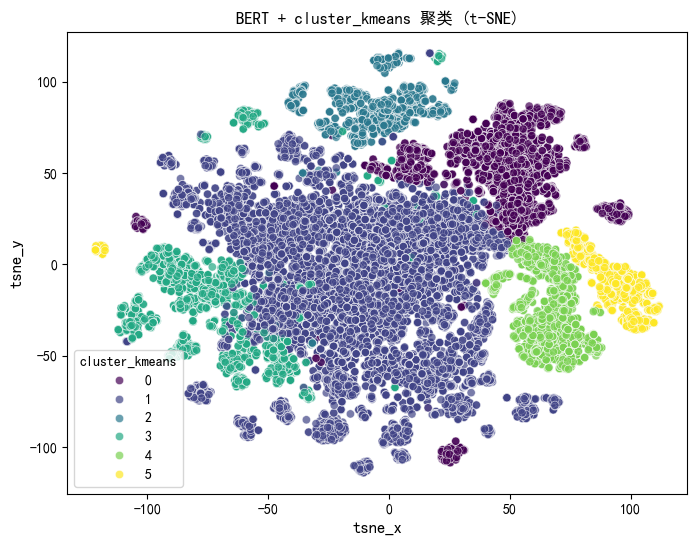

聚类结果已保存至 .\BERT_embeding_cluster\BERT -cluster_dbscan 聚类 (t-SNE).png


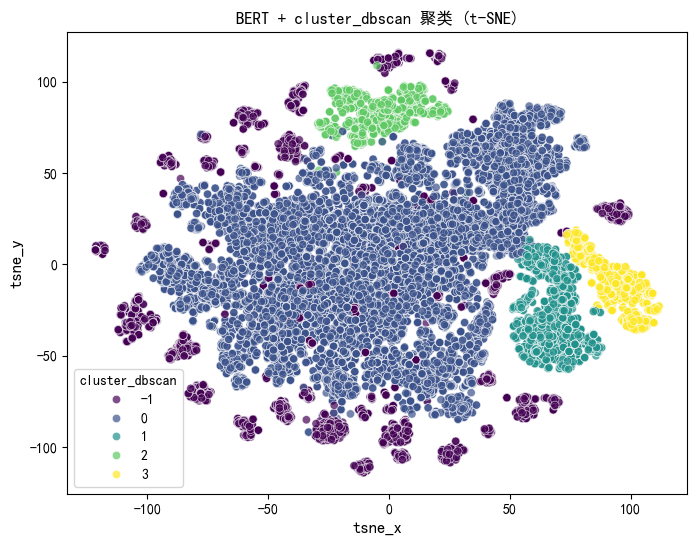

聚类结果已保存至 .\BERT_embeding_cluster\BERT -cluster_hdbscan 聚类 (t-SNE).png


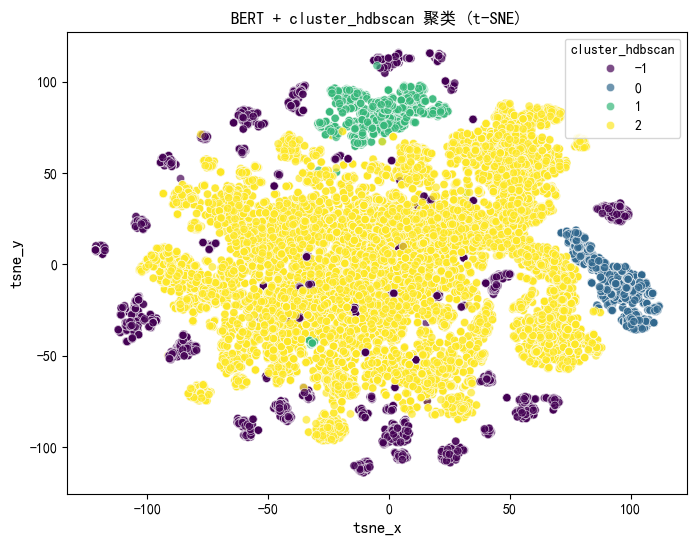

In [52]:
def cluster_plot(cluster_label):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x="tsne_x", y="tsne_y", hue=cluster_label, palette="viridis", alpha=0.7)
    plt.title(f"BERT + {cluster_label} 聚类 (t-SNE)")

    save_path = f'.\BERT_embeding_cluster\BERT -{cluster_label} 聚类 (t-SNE).png'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"聚类结果已保存至 {save_path}")

    plt.show()


for cluster_label in ['cluster_kmeans','cluster_dbscan','cluster_hdbscan']:
    cluster_plot(cluster_label)

In [53]:
# # 使用 UMAP 进行降维
# umap_reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
# umap_embeddings = umap_reducer.fit_transform(sentence_embeddings)

# # 将 UMAP 结果加入 DataFrame
# df["umap_x"] = umap_embeddings[:, 0]
# df["umap_y"] = umap_embeddings[:, 1]

# def cluster_plot_nmap(df,cluster_label):
#     plt.figure(figsize=(8, 6))
#     sns.scatterplot(data=df, x="umap_x", y="umap_y", hue=df[cluster_label], palette="viridis", alpha=0.7)
#     plt.title(f"BERT + {cluster_label} 聚类 (UMAP)")

#     save_path = f'./BERT_embeding_cluster/BERT-{cluster_label} 聚类 (UMAP).png'
#     os.makedirs(os.path.dirname(save_path), exist_ok=True)

#     plt.savefig(save_path, dpi=300, bbox_inches='tight')
#     print(f"聚类结果已保存至 {save_path}")

#     plt.show()

# # 依次绘制 KMeans、DBSCAN、HDBSCAN 的聚类结果
# for cluster_label in ['cluster_kmeans', 'cluster_dbscan', 'cluster_hdbscan']:
#     cluster_plot_nmap(df,cluster_label)


In [54]:
df_cluster_means =  df[['商品名称', '商品分类', '商品品牌',
                        'cluster_kmeans','cluster_dbscan','cluster_hdbscan',"tsne_x",'tsne_y']]

In [55]:
df_cluster_means.to_csv('.\BERT_embeding_cluster\BERT_cluster_means.csv', index=False)